# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: G9
- Carlota Monedero Herranz
- José Manuel Vega Gradit
- Jorge Ayuso Martínez
- Javier Gisbert Gil
- Diego Sanz-Gadea Sánchez

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


---
Importamos todos los paquetes aquí por comodidad

In [1]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Libreríasc clásicas de Data Science
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Scikit-Learns modules
# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# Modelling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

# Metrics
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibratedClassifierCV

# mltools
from mltools import classification_tools as CT
from mltools import model_tools as MT

Para mejorar la estética de las gráficas, hacemos uso de `seaborn`:

In [2]:
sns.set()

Con el siguiente comando podemos calibrar el número de columnas del DataFrame que se muestran:

In [3]:
pd.set_option('display.max_columns', None)

## 1. AJUSTE DE LOS MODELOS CON EL DATASET `AJU_DATOS_DEM_C3.csv`

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni AÑO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

#### Carga de datos:

In [4]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = pd.read_csv('data/input/AJU_DATOS_DEM_C3.csv')

# Parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# Nota: esta variable NO se puede utilizar como entrada en los modelos
df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format="%d/%m/%Y") 
s = df_aju.loc[:, 'FECHA']
df_aju['FECHA'] =  s.dt.date

# Eliminamos las variables que no se pueden usar como entradas en los modelos
del df_aju['ANNO']
del df_aju['DIA']

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju.head()

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,CR10,CR11,CR12,CR13,CR14,CR15,CR16,CR17,CR18,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2014-01-01,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,0.039427,0.041801,0.042122,0.042366,0.043396,0.042980,0.040835,0.041026,0.044652,0.051983,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,1,12.3,20.2
1,2014-01-02,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,0.045132,0.046170,0.045324,0.044659,0.045434,0.045281,0.043589,0.043362,0.045939,0.052936,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,0,12.0,20.1
2,2014-01-03,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,0.046046,0.047047,0.044796,0.044318,0.044846,0.044694,0.043458,0.043363,0.045908,0.052802,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,0,13.2,21.0
3,2014-01-04,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,0.044597,0.046754,0.046050,0.044611,0.045670,0.045926,0.044732,0.044316,0.046249,0.051650,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,0,14.4,23.4
4,2014-01-05,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,0.043760,0.045930,0.045478,0.044804,0.045645,0.045275,0.043290,0.043349,0.046256,0.051721,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,0,12.8,23.1


#### Visión general de las series:

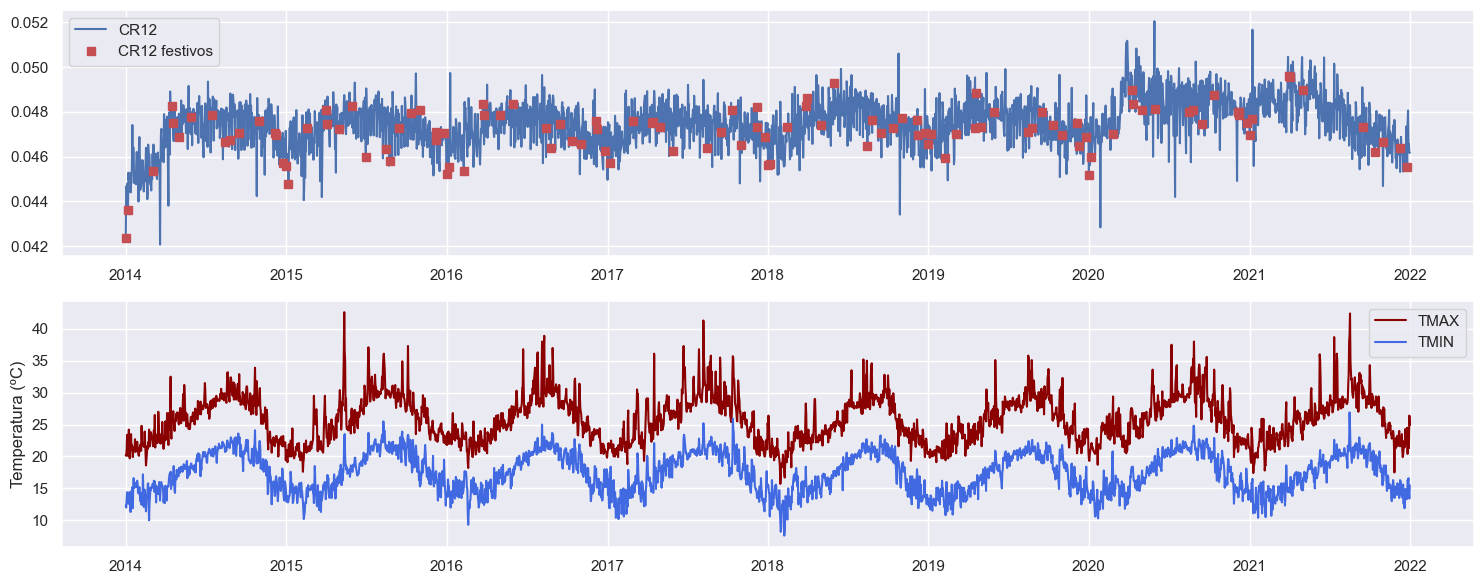

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))

ax1 = plt.subplot(2, 1, 1)
ind_festivo = df_aju.FESTIVO == 1
plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')
plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2, 1, 2,sharex = ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX', color="darkred")
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN', color="royalblue")
plt.ylabel("Temperatura (ºC)")
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

Vemos en primer lugar los tipos de datos de cada variable, así como la posible existencia de valores nulos:

In [6]:
# Ver datatypes
df_aju.dtypes

FECHA       object
CR00       float64
CR01       float64
CR02       float64
CR03       float64
CR04       float64
CR05       float64
CR06       float64
CR07       float64
CR08       float64
CR09       float64
CR10       float64
CR11       float64
CR12       float64
CR13       float64
CR14       float64
CR15       float64
CR16       float64
CR17       float64
CR18       float64
CR19       float64
CR20       float64
CR21       float64
CR22       float64
CR23       float64
MES          int64
DIASEM       int64
FESTIVO      int64
TMIN       float64
TMAX       float64
dtype: object

In [7]:
# Revisamos que columnas tienen valores nulos
null_values = df_aju.isnull().sum()
null_values[null_values>0].index.tolist()

[]

Podemos observar que ninguna columna tiene valores nulos. Adicionalmente, los tipos de datos son los correctos, de forma que no es necesario realizar ningún cambio al respecto.

A continuación vamos a analizar los datos que tenemos desde un punto de vista estadístico:

In [8]:
df_aju.describe()

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,CR10,CR11,CR12,CR13,CR14,CR15,CR16,CR17,CR18,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
count,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000
mean,0.034957,0.032494,0.030964,0.030305,0.030266,0.031063,0.033603,0.037270,0.041366,0.045223,0.047050,0.046984,0.047507,0.048261,0.047648,0.045344,0.044218,0.045380,0.047876,0.049790,0.050401,0.049120,0.043973,0.038937,6.526224,4.006600,0.039944,17.460056,25.821639
std,0.001606,0.002285,0.001341,0.001227,0.001107,0.000955,0.000871,0.002104,0.002057,0.001498,0.000995,0.000910,0.001037,0.001222,0.001100,0.001059,0.001060,0.001242,0.002294,0.002797,0.002089,0.001359,0.001388,0.001344,3.444273,1.994683,0.195863,3.081945,3.677193
min,0.030414,0.027836,0.026304,0.026362,0.027067,0.027963,0.028263,0.030260,0.017153,0.028013,0.041063,0.041689,0.042062,0.043123,0.042364,0.040525,0.038784,0.039004,0.040209,0.041802,0.043542,0.043666,0.038585,0.033029,1.000000,1.000000,0.000000,7.600000,15.700000
25%,0.033770,0.031340,0.029996,0.029424,0.029463,0.030361,0.033031,0.035427,0.039913,0.044453,0.046573,0.046431,0.046872,0.047506,0.046980,0.044656,0.043499,0.044684,0.046561,0.047863,0.048883,0.048259,0.043005,0.037990,4.000000,2.000000,0.000000,15.000000,22.900000
50%,0.034726,0.032124,0.030687,0.030060,0.030074,0.030938,0.033557,0.037093,0.041499,0.045344,0.047134,0.047041,0.047549,0.048249,0.047667,0.045364,0.044224,0.045475,0.047744,0.049314,0.050434,0.049143,0.043962,0.038882,7.000000,4.000000,0.000000,17.500000,25.600000
75%,0.035922,0.033320,0.031802,0.031081,0.030968,0.031709,0.034129,0.039217,0.043018,0.046244,0.047669,0.047585,0.048188,0.049009,0.048352,0.046078,0.044959,0.046270,0.049166,0.052280,0.051931,0.050033,0.044932,0.039817,10.000000,6.000000,0.000000,20.200000,28.500000
max,0.040942,0.067164,0.036382,0.035336,0.034789,0.034929,0.037046,0.041914,0.045876,0.048957,0.050939,0.049904,0.052055,0.054524,0.053118,0.048681,0.047659,0.048516,0.054592,0.057206,0.056826,0.053625,0.049216,0.043856,12.000000,7.000000,1.000000,26.900000,42.600000


### Visualización

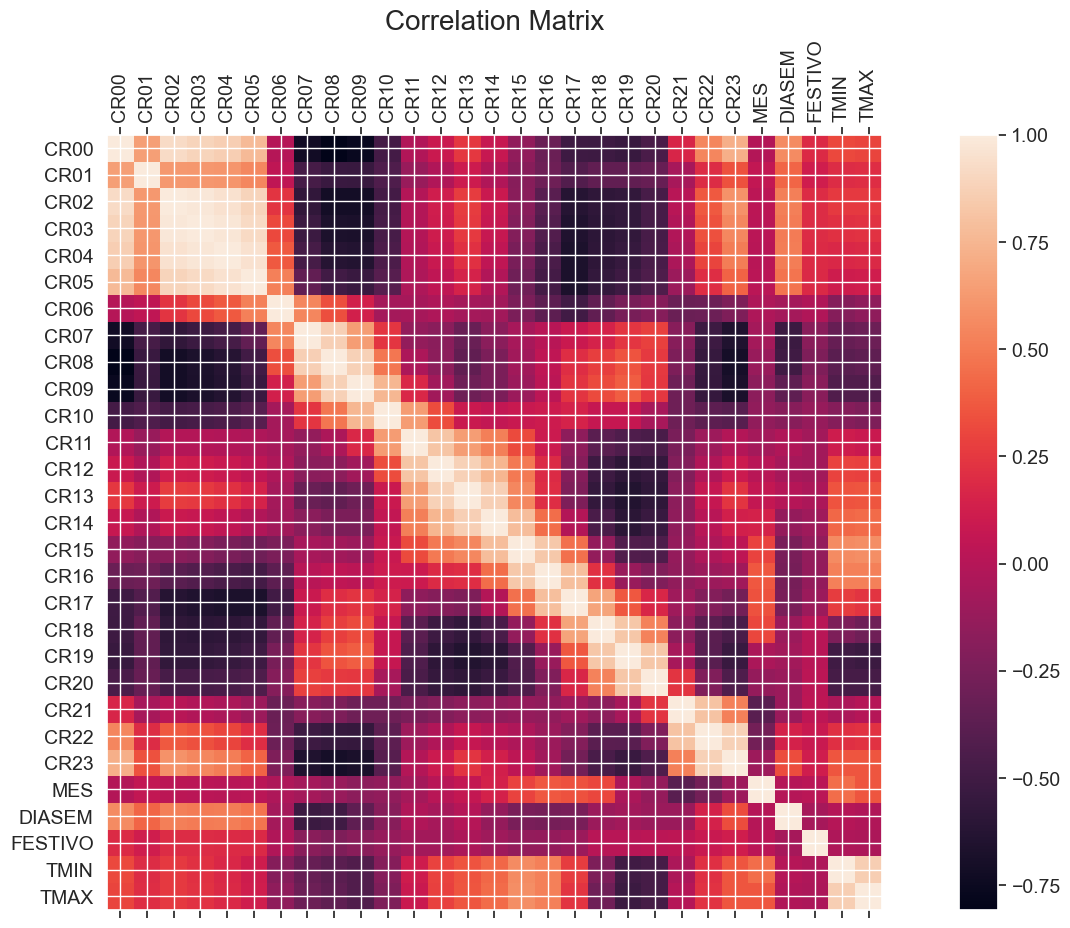

In [9]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Correlation plot of numeric variables
f = plt.figure(figsize=(20,10))
plt.matshow(df_aju.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)

plt.xticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), 
           df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=90)

plt.yticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), 
           df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)
plt.show()

Se pueden apreciar correlaciones muy importantes entre algunos pares de variables. Sin especificar en detalle todas estas correlaciones debido a la existencia de un gran número de ellas, podemos apreciar que algunas de las más relevantes son:

- Correlación muy positiva entre los coeficientes de reparto del $CR00$ al $CR05$.
- Correlación muy negativa entre los coeficientes de reparto $CR00...CR05$ y los coeficientes de reparto $CR07...CR10$.
- Correlación muy negativa entre los coeficientes de reparto $CR00...CR05$ y los coeficientes de reparto $CR16...CR20$.
- Correlación muy negativa entre los coeficientes de reparto $CR12...CR15$ y los coeficientes de reparto $CR18...CR20$.
- En general parece haber una correlación positiva entre coeficientes de reparto consecutivos, como $CR21$ y $CR22$, lo cual tiene cierto sentido desde un punto de vista lógico. Obviamente esta correlación es más clara en algunos casos que en otros.
- Correlación bastante positiva entre $T_{min}$ y $T_{max}$.

Hay que tener en cuenta que con este gráfico solamente somos capaces de detectar correlaciones lineales entre los datos, de forma que pueden existir otras correlaciones existentes que no sigan una relación estrictamente lineal, y que habrá que estudiar, si existen, más en detalle en siguientes puntos.

#### Variables cuantitativas discretas

Con el uso de la función que se muestra abajo procedemos a estudiar si existe alguna relación entre la variable de salida y las variables cuantitativas discretas de nuestro dataset.

In [10]:
target = "FESTIVO"

In [11]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def discrete_graph(df0, df1, input):
    plt.figure(figsize=(7, 3), dpi=150)
    plt.bar(x=df0[input].value_counts().sort_index().index, height=df0[input].value_counts(normalize=True).sort_index(), 
            align='edge', width=-0.4, color="navy", label="0")
    plt.bar(x=df1[input].value_counts().sort_index().index, height=df1[input].value_counts(normalize=True).sort_index(), 
            align='edge', width=0.4, color="dodgerblue", label="1")
    plt.legend()
    title = input + ' distribution'
    plt.title(title)
    plt.ylabel('Relative Frequency')
    plt.xticks([i for i in range(df0[input].max()+1)])
    plt.show()

In [12]:
# This will helps us with the visualization
df_aju_0 = df_aju.loc[df_aju[target]==0]
df_aju_1 = df_aju.loc[df_aju[target]==1]

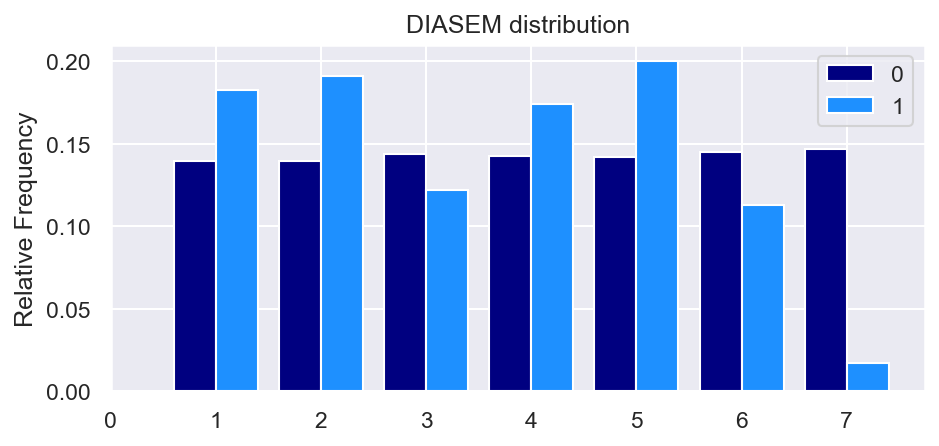

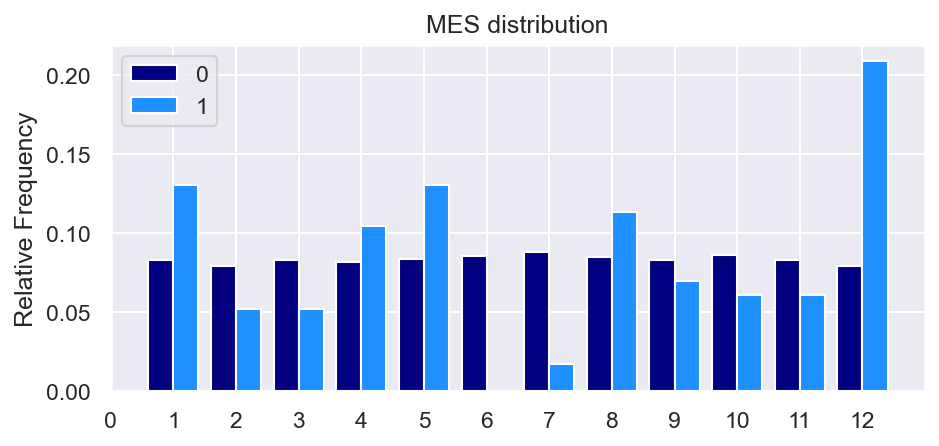

In [13]:
discrete = ["DIASEM", "MES"]
for variable in discrete:
    discrete_graph(df_aju_0, df_aju_1, variable)

Vemos que tanto el mes como el día de la semana parecen variables relevantes para predecir sin un día es festivo o no.

**Respecto al día de la semana**:

Podríamos pensar que la relación existente el día de la semana se debe a que tenemos una muestra finita de datos, dado que cada año un día en concreto (por ejemplo el día de Navidad) se encuentra en el siguiente día de la semana (es decir, un año cae en lunes, al siguiente en martes, al siguiente en miércoles, etc). Sin embargo, si analizamos la cantidad de datos de los que disponemos:

In [14]:
len(df_aju)/365

7.887671232876713

Vemos que tenemos datos de prácticamente 8 años, por lo que esa diferencia entre días festivo por día de la semana no se debe a que tenemos datos de pocos años, sino a que realmente existe una relación. Por ejemplo, podemos ver que generalmente los festivos no caen en domingo, por que se suelen aplazar a otro día de la semana.

**Respecto al mes**:

Vemos que claramente hay meses que tienen más días festivos que otros, siendo Diciembre el mes con más días festivos del año, y Junio el que menos.

#### Variables cuantitativas continuas

Con el uso de la función que se muestra abajo procedemos a estudiar si existe alguna relación entre la variable de salida y las variables cuantitativas continuas de nuestro dataset.

In [15]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def continous_graph(df, input, target): 
    sns.set(rc={'figure.figsize':(16,5)})
    fig, axs = plt.subplots(ncols=2)
    
    dens_plot = sns.histplot(data = df, x = input, hue=target, kde = True, palette=['royalblue', 'midnightblue'], ax=axs[0])
    axs[0].set_title('Distribution of the variable', fontdict={'fontsize':15})
    axs[0].axvline(x=df.loc[df[target] == 0][input].mean(), color='royalblue', ls='--')
    axs[0].axvline(x=df.loc[df[target] == 1][input].mean(), color='midnightblue', ls='--')

    boxplot = sns.boxplot(data=df , y=input, x=target, palette=['#6E91FF', '#00175F'], 
                          width=0.3, ax=axs[1], **{'medianprops':{'color':'gray'}})
    axs[1].set_ylabel(input, fontdict={'fontsize':15})   
    axs[1].set_title('Boxplot for each value of the target variable', fontdict={'fontsize':15})
    plt.show()
    return(dens_plot, boxplot)

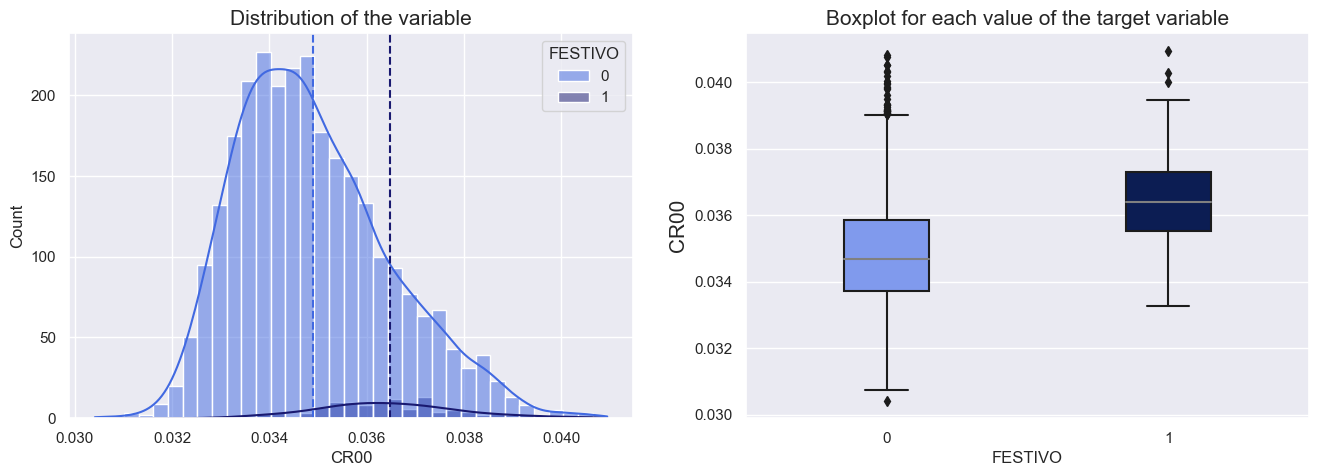

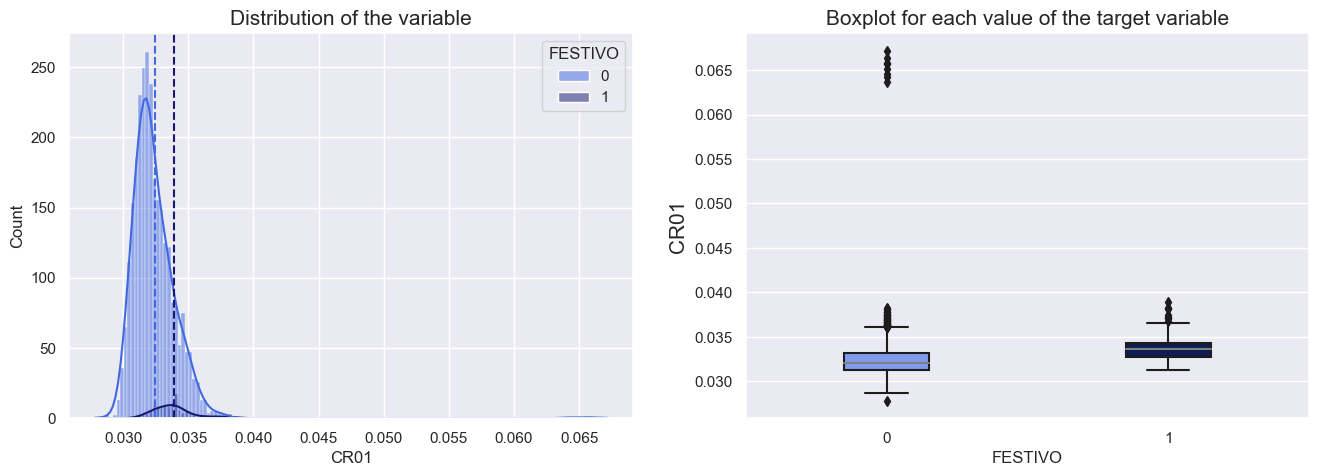

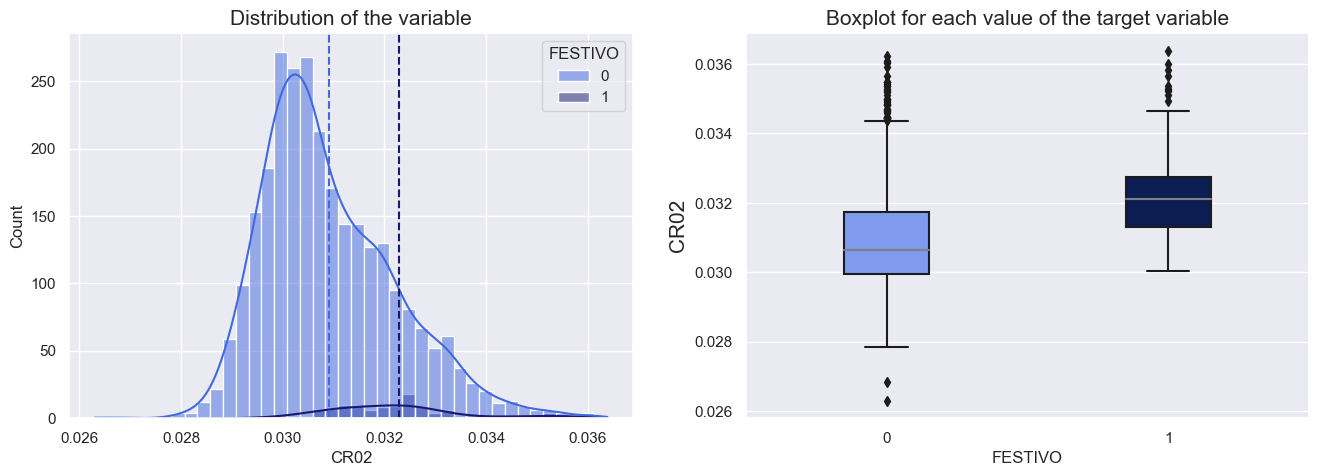

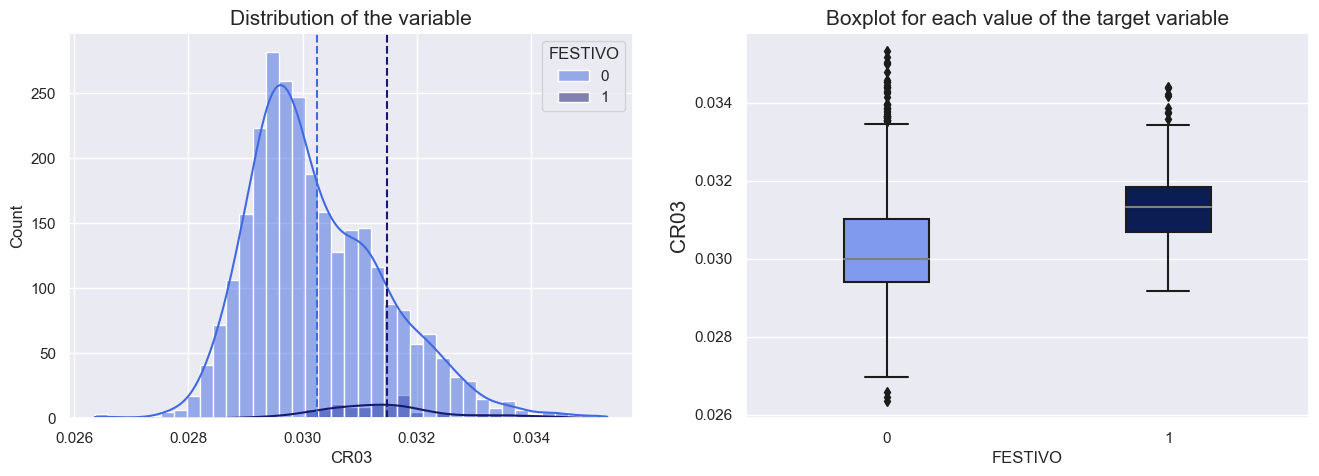

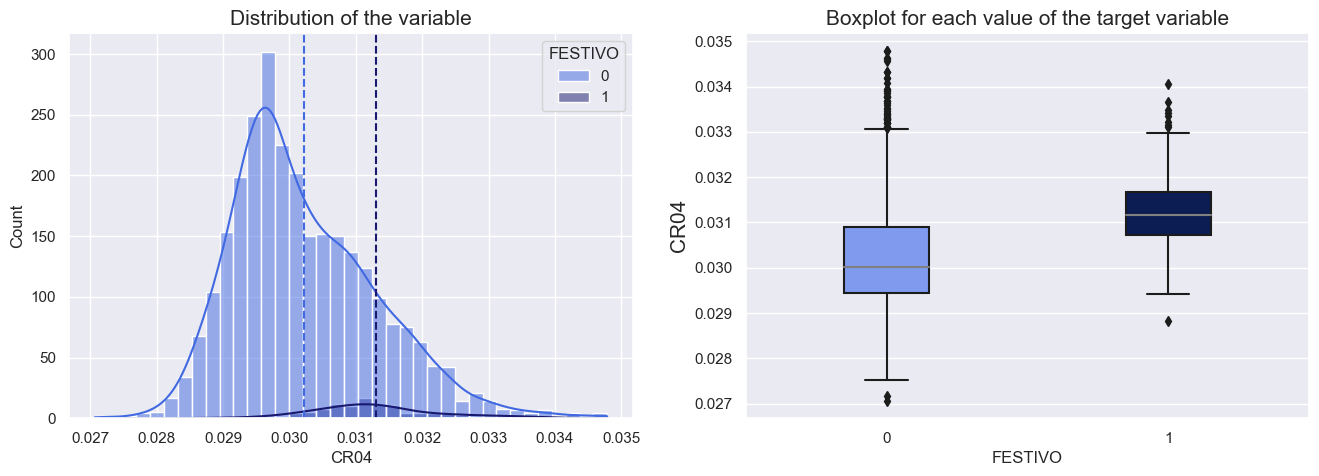

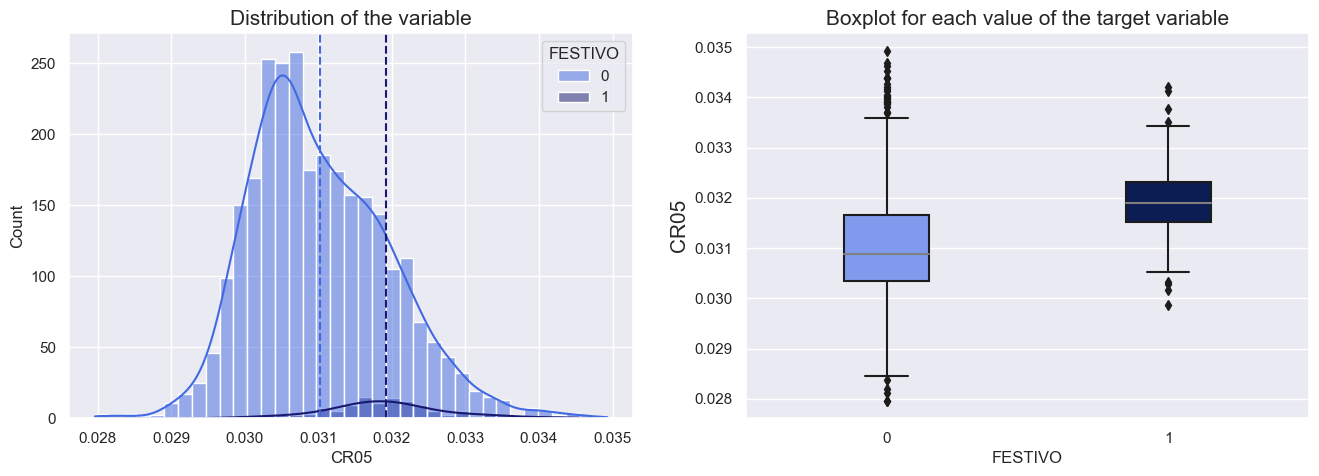

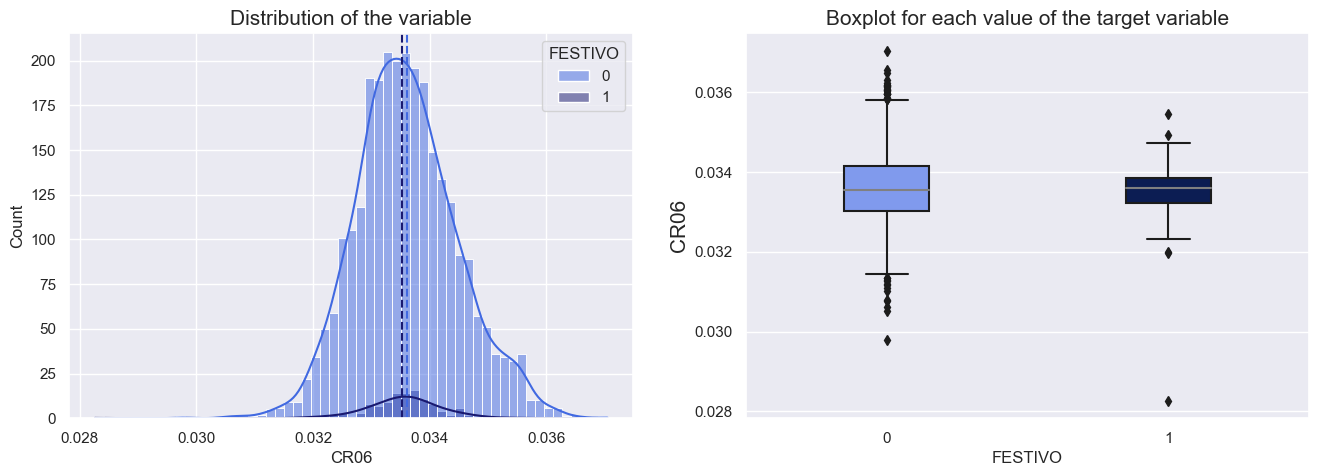

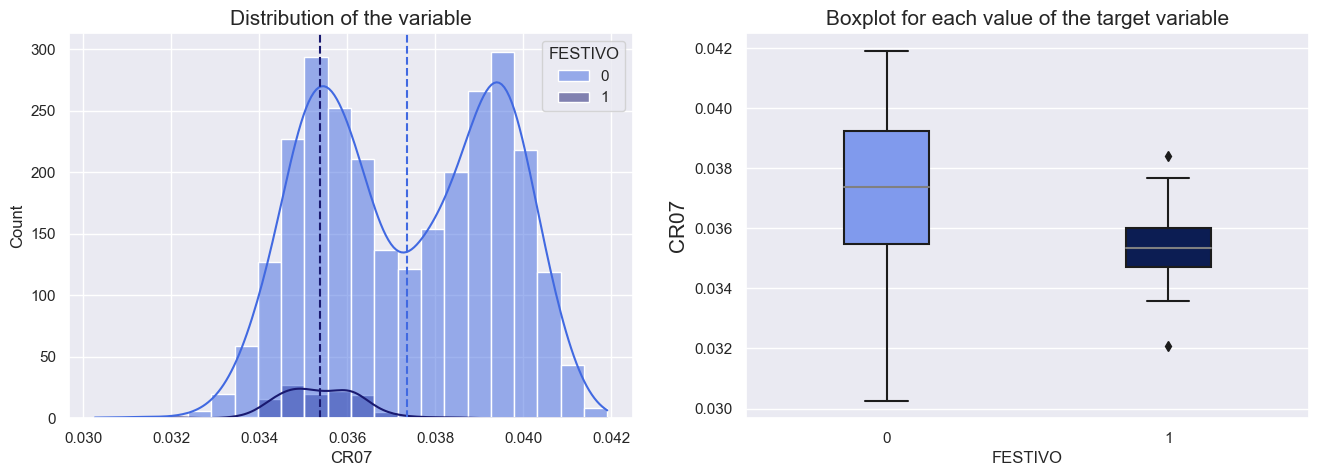

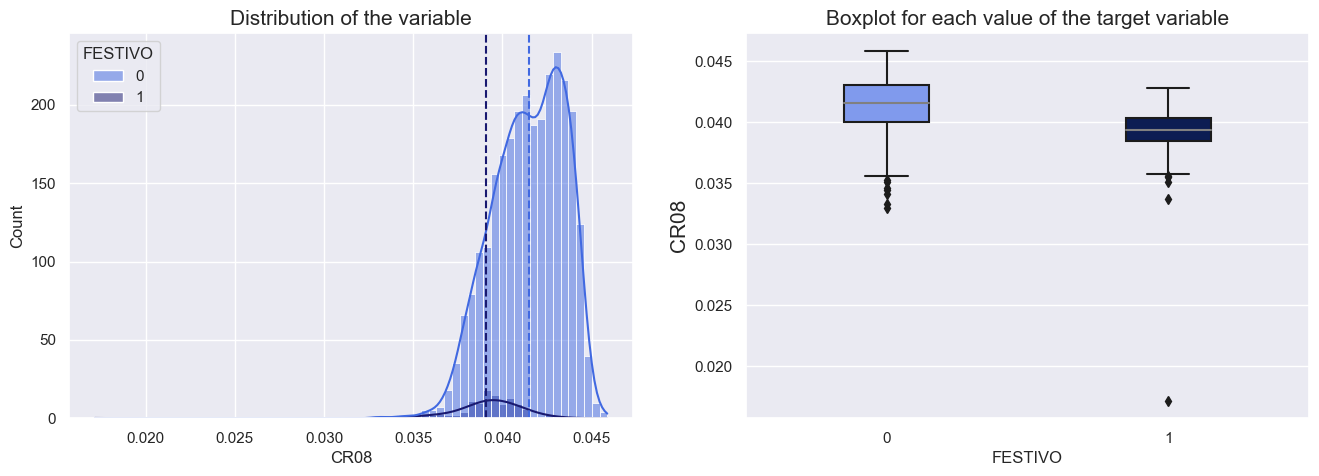

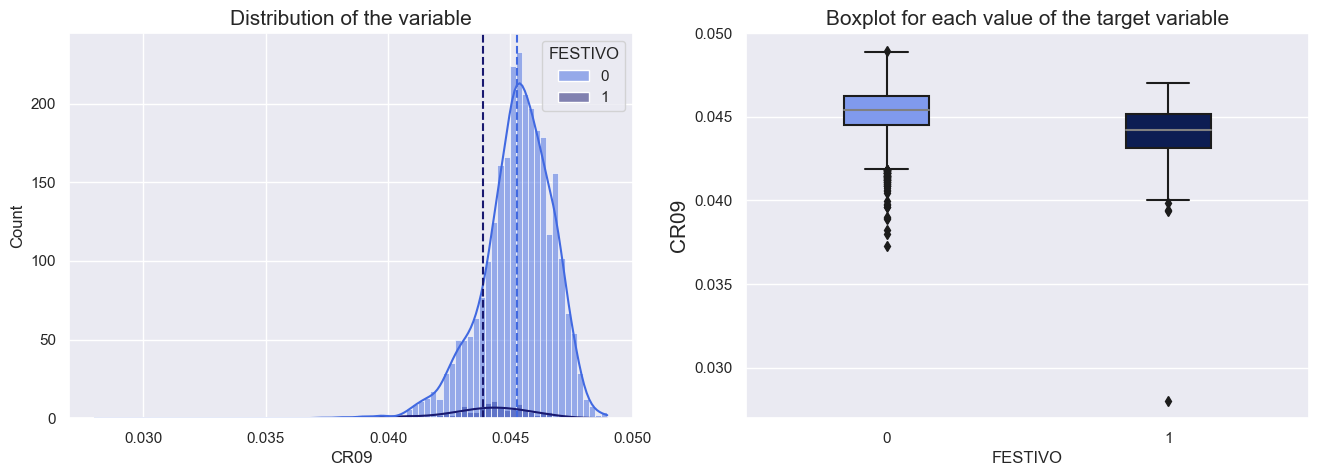

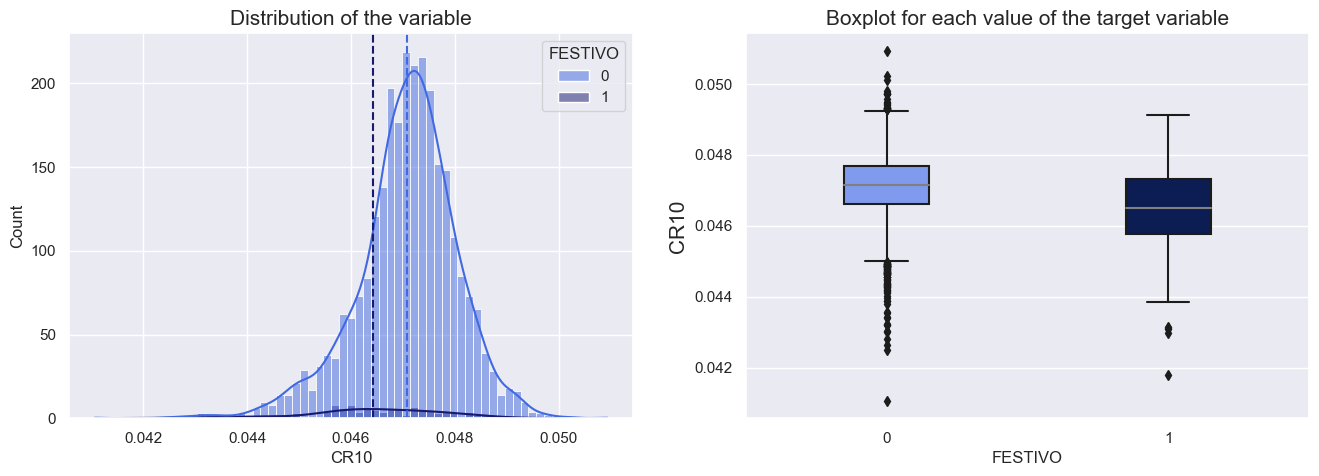

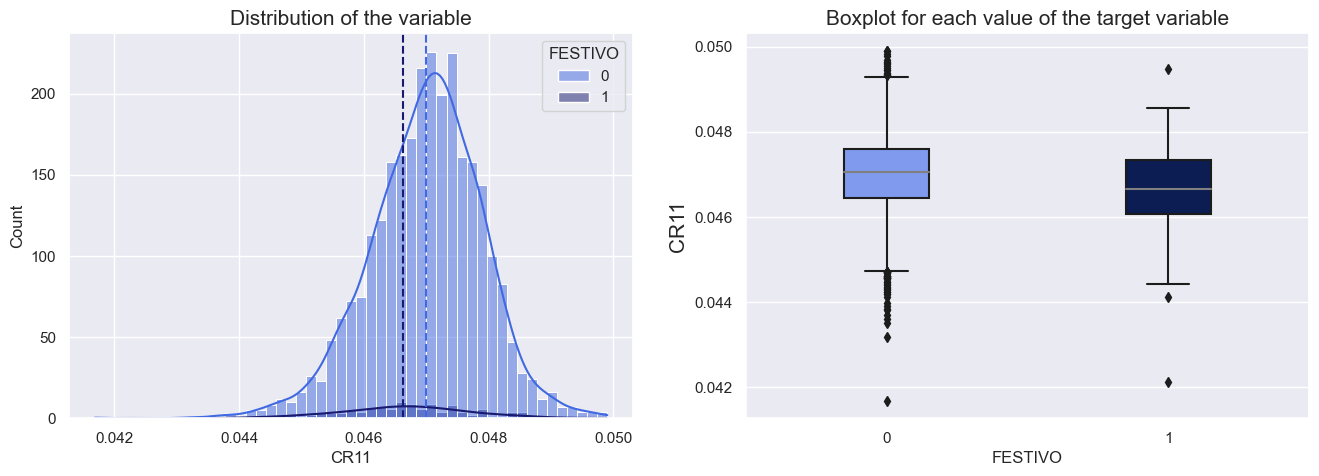

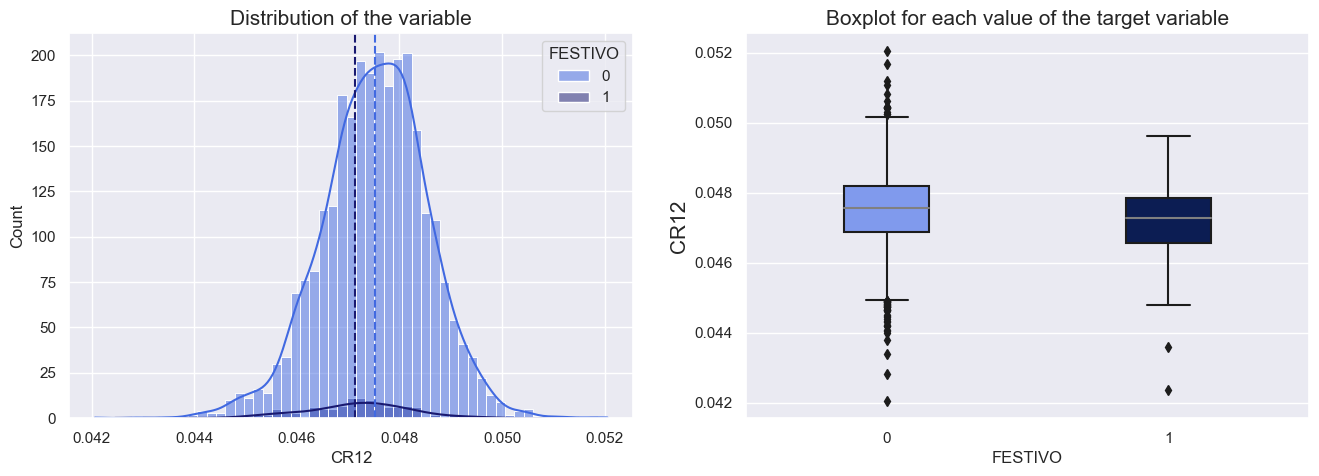

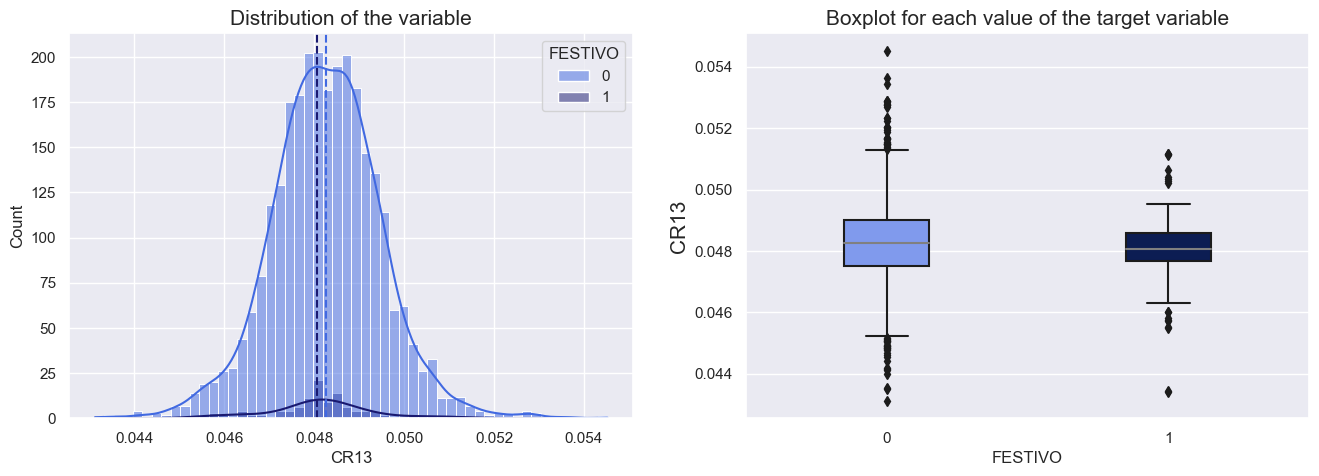

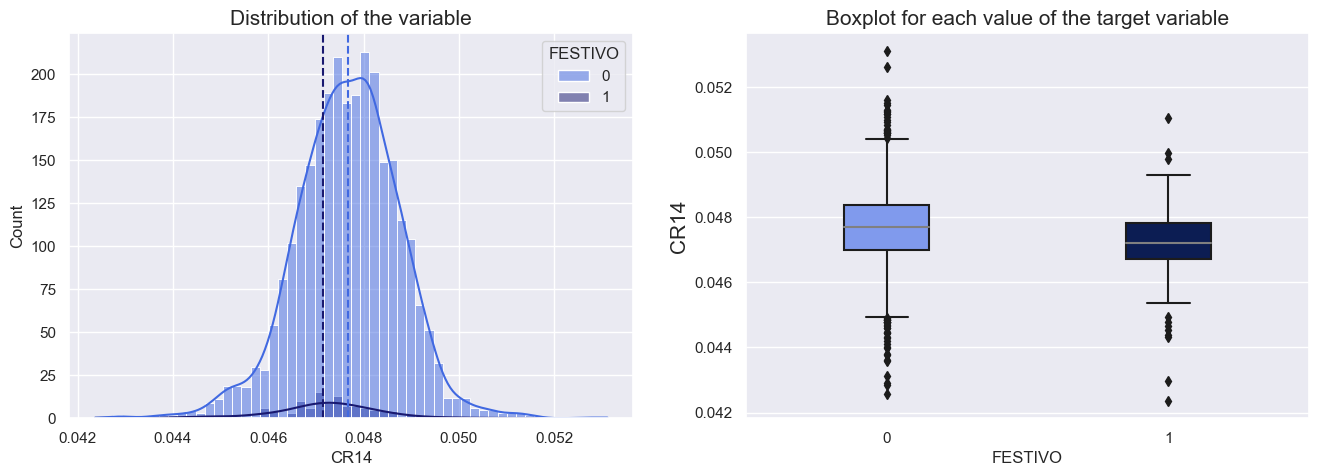

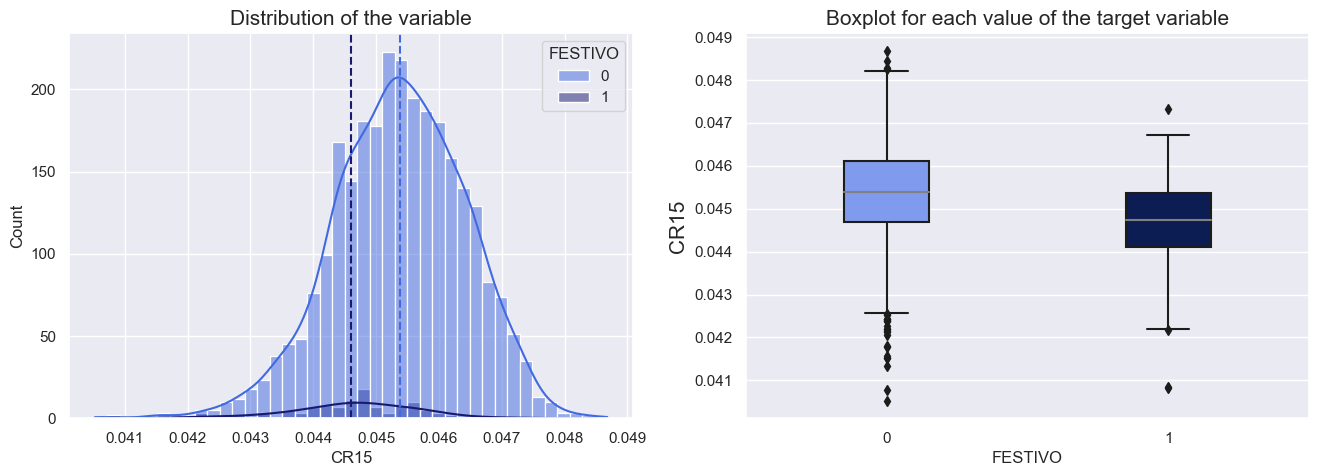

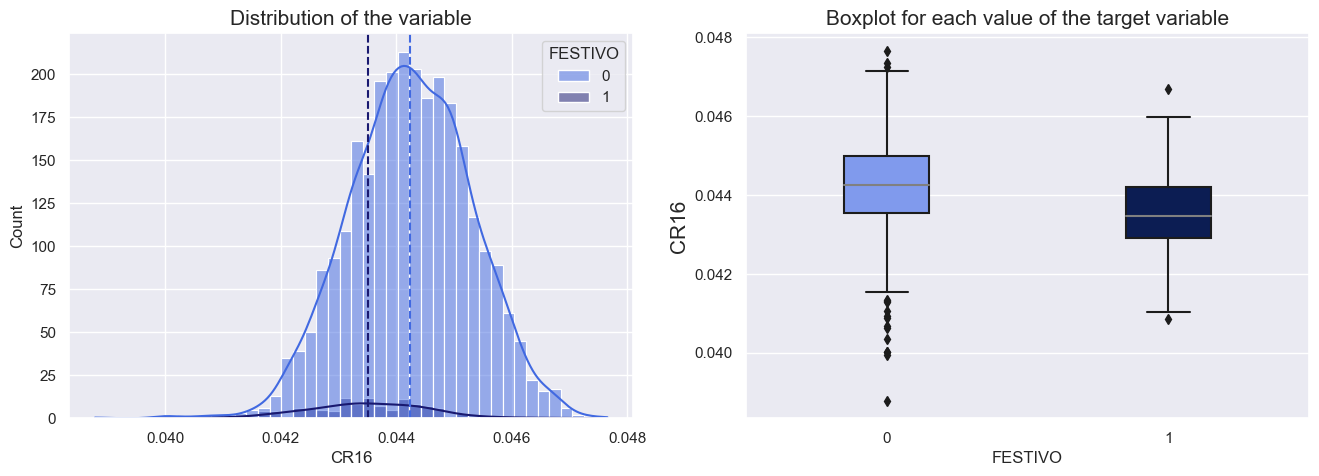

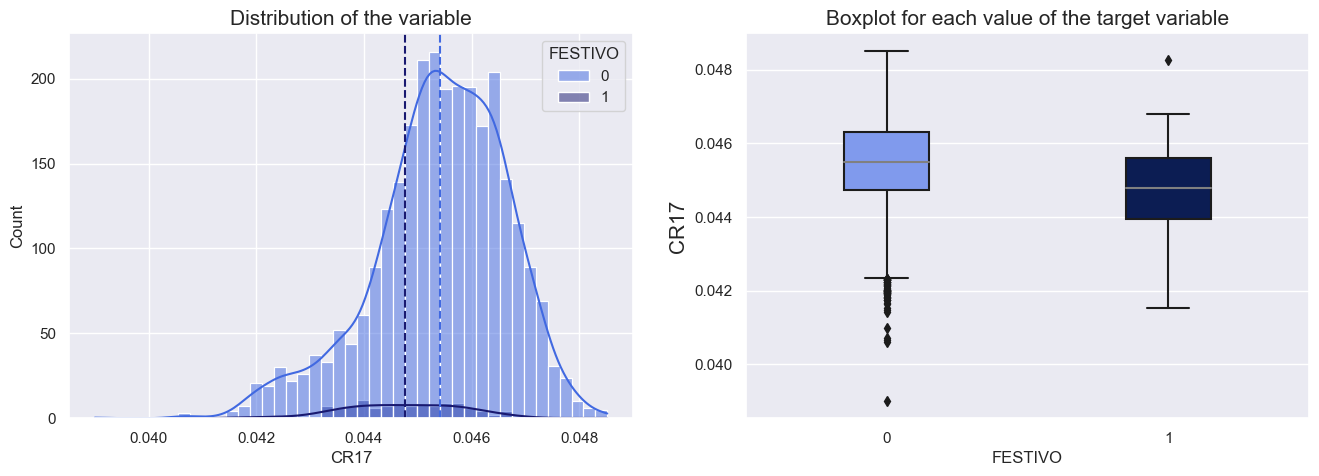

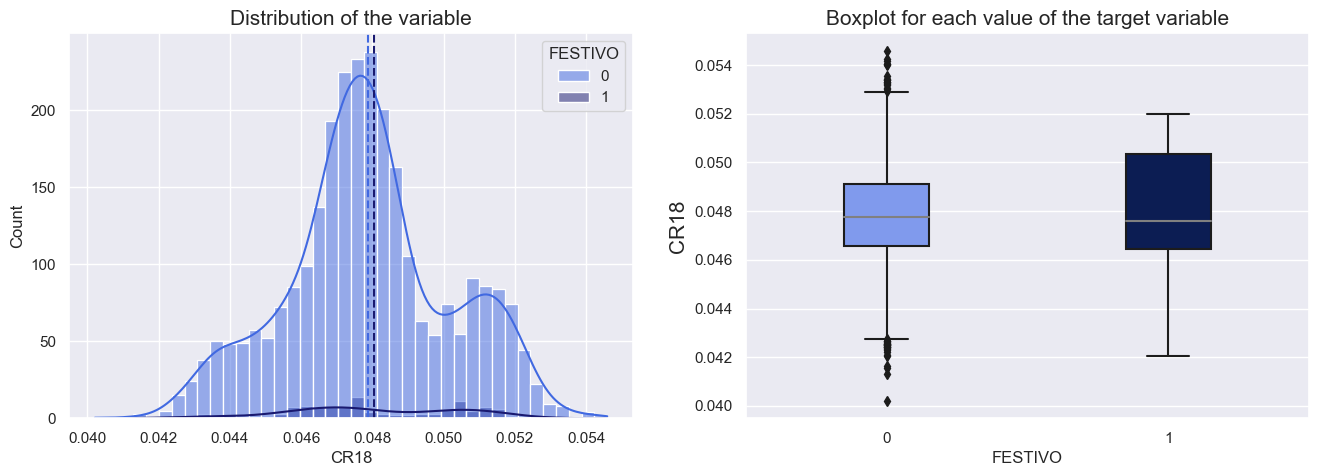

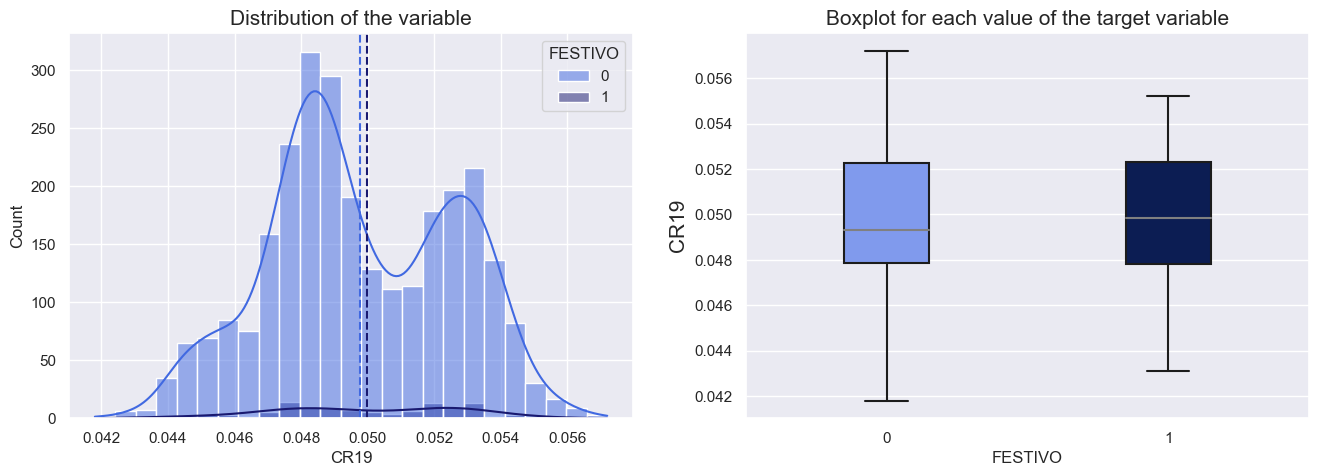

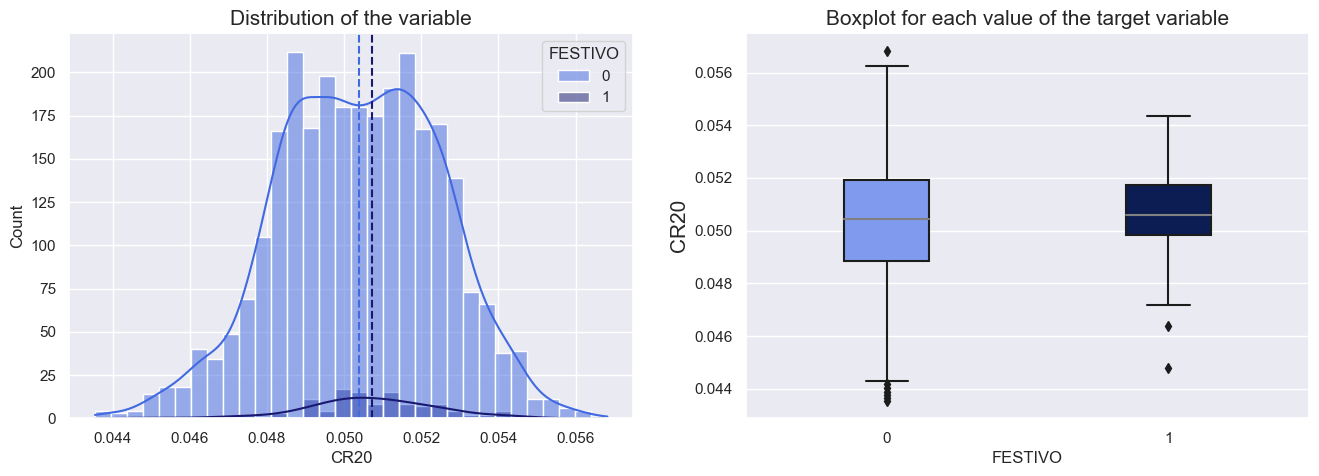

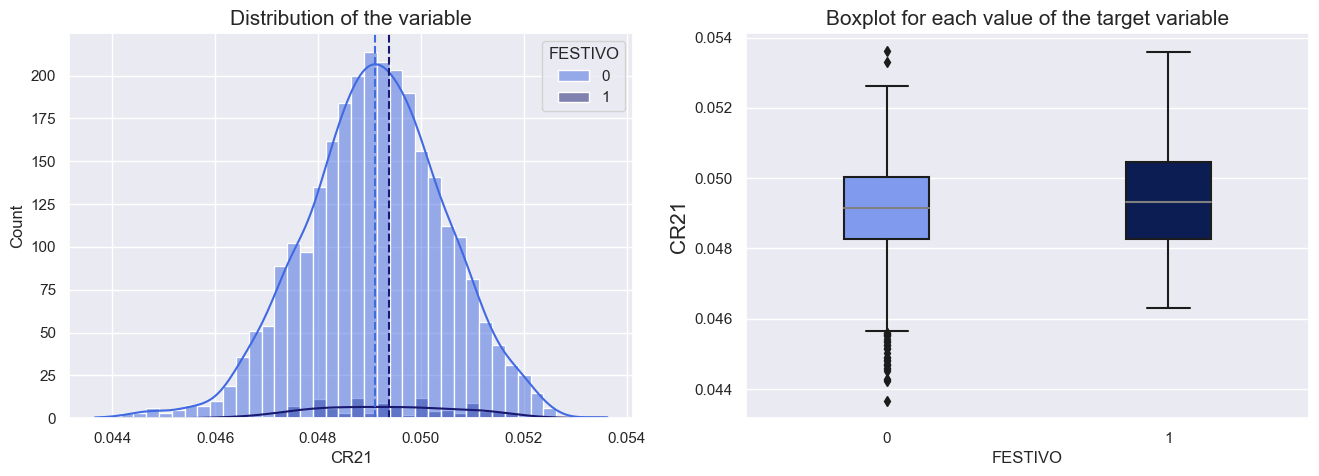

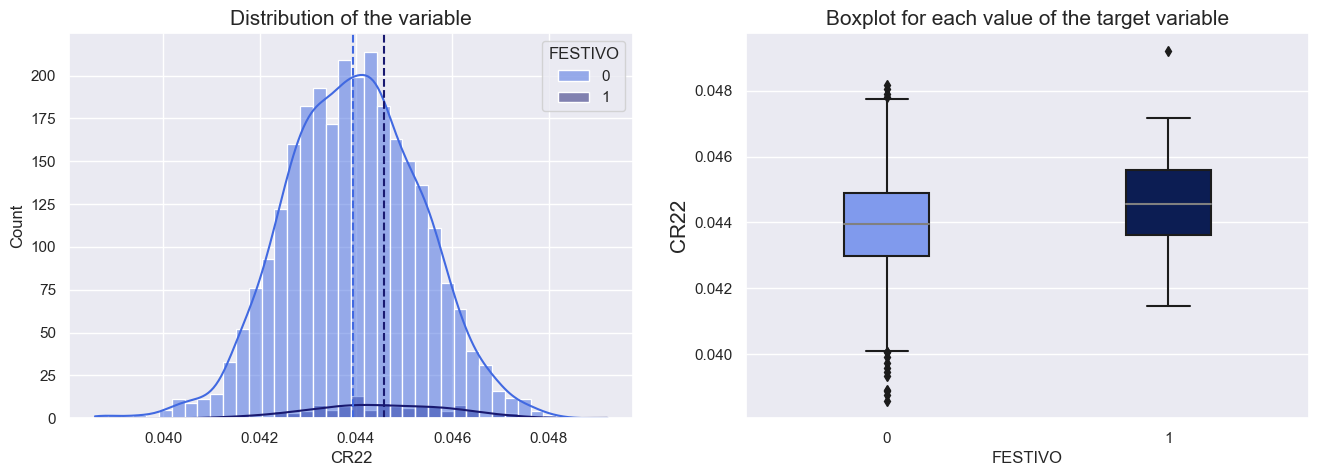

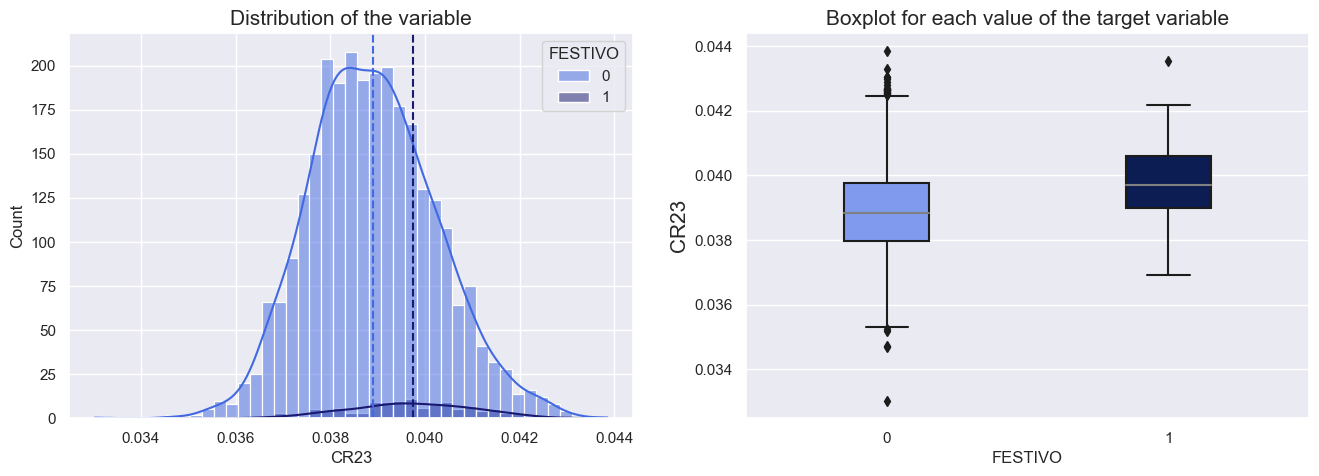

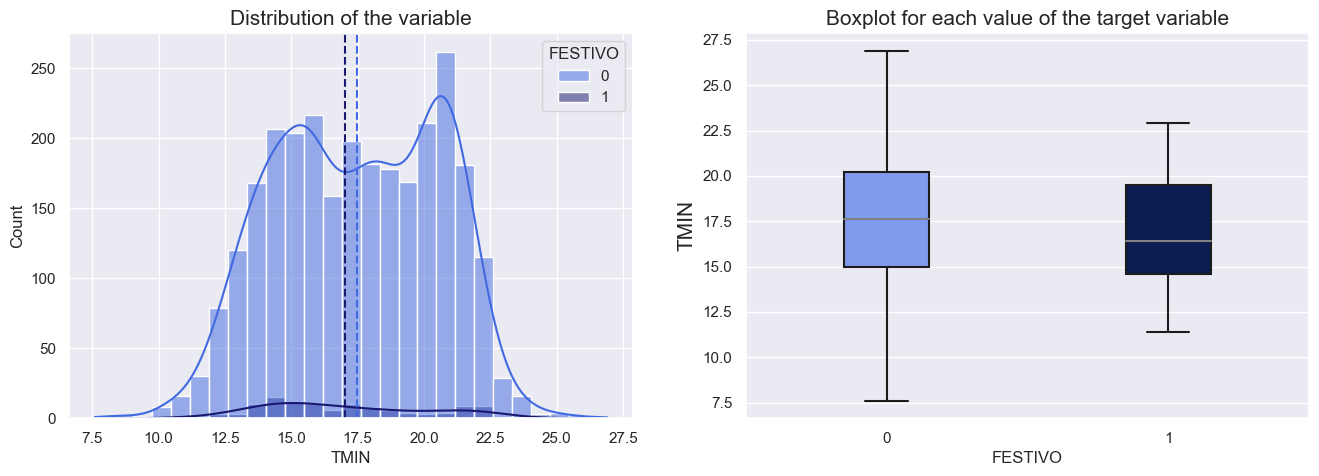

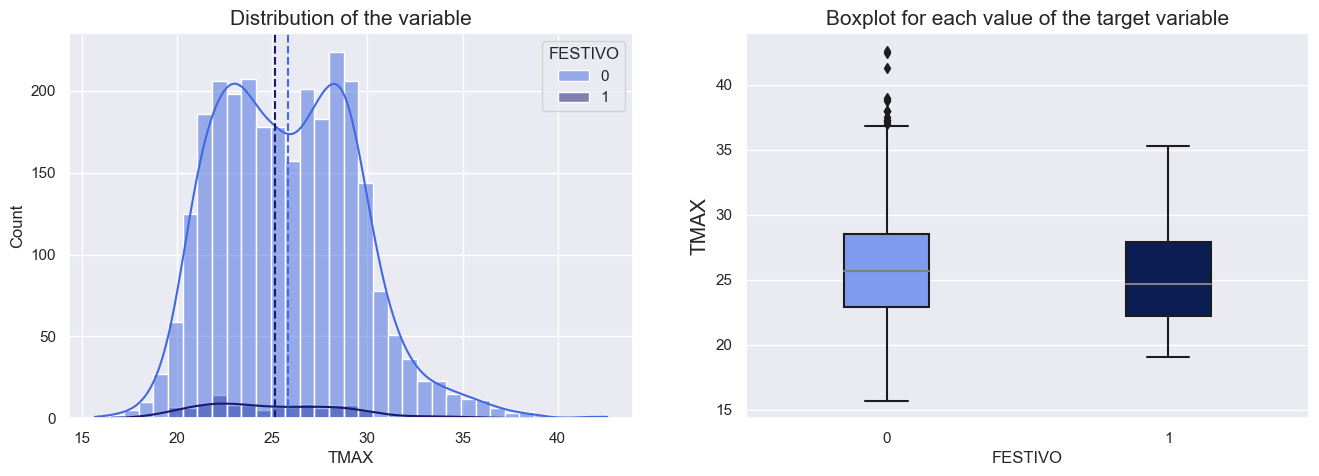

In [16]:
continuous = ['CR00','CR01','CR02','CR03','CR04','CR05','CR06','CR07','CR08','CR09','CR10','CR11','CR12','CR13',
              'CR14','CR15','CR16','CR17','CR18','CR19','CR20','CR21','CR22','CR23','TMIN','TMAX']
for variable in continuous:
    continous_graph(df_aju, variable, target)

Pese a que no se aprecia tan claramente la distribución correspondiente a los días festivos, gracias a los boxplots, así como a las medias de las distribuciones (líneas discontinuas verticales), podemos apreciar que no para todas las variables la media de ambas distribuciones son igual de parecidas. En consecuencia, podemos apreciar que algunas variables parecen ser más útiles de cara a discriminar días festivos de días no festivos, como por ejemplo:

- $CR00$
- $CR07$
- $CR08$

### Outliers

Vamos también a ver el porocentaje de outliers que tiene cada variable haciendo uso de la fórmula clásica para el cálculo de estos:

In [17]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def detect_outliers(df, column_name):
    y = df.loc[:, column_name]
    iqr = stats.iqr(y)
    first_quantile, third_quantile = np.quantile(y, [0.25, 0.75])
    cut_low = first_quantile - 1.5 * iqr
    cut_high = third_quantile + 1.5 * iqr
    outliers = y.loc[(y < cut_low) | (y > cut_high)]
    return f"{column_name} : {np.round(100*outliers.count()/len(df), 1)}%"

In [18]:
out_list = continuous
for i in out_list:
    print(detect_outliers(df_aju, i))

CR00 : 0.9%
CR01 : 1.7%
CR02 : 1.6%
CR03 : 1.6%
CR04 : 1.4%
CR05 : 1.0%
CR06 : 1.4%
CR07 : 0.0%
CR08 : 0.3%
CR09 : 2.4%
CR10 : 3.9%
CR11 : 1.9%
CR12 : 1.8%
CR13 : 2.3%
CR14 : 2.2%
CR15 : 1.0%
CR16 : 0.6%
CR17 : 2.0%
CR18 : 1.3%
CR19 : 0.0%
CR20 : 0.3%
CR21 : 1.1%
CR22 : 0.6%
CR23 : 0.7%
TMIN : 0.0%
TMAX : 0.5%


Vemos que en ningún caso se supera el porcentaje de crítico del $5\%$ que típicamente se toma como umbral para determinar si el porcentaje de outliers es excesivo. Vemos adicionalmente que en algunos casos este porcentaje es mayor que en otros, como por ejemplo de la variable explicativa $CR10$ donde el porcentaje es prácticamente del $4\%$

#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

Es importante en los problemas de clasificación asegurarse de que el porcentaje de datos que pertenece a cada clase es el mismo en ambos datasets (train y test), de forma que que ambos datasets son representativos de la población de salida. Para ello, usaremos la clase `StratifiedShuffleSplit` de `scikit-learn`. De esta forma, la frecuencia relativa de la variable de salida es la misma en ambos sets.

In [19]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2023)
for train_index, test_index in split.split(df_aju, df_aju[target]):
    df_aju_tr = df_aju.loc[train_index]
    df_aju_ts = df_aju.loc[test_index]

Tras dividir los datos en training y test vamos a comprobar que efectivamente la frecuencia relativa de las dos clases de la variable de salida es prácticamente idéntico en ambos casos.

In [20]:
df_aju_tr[target].value_counts(normalize=True).sort_index()

0    0.960052
1    0.039948
Name: FESTIVO, dtype: float64

In [21]:
df_aju_ts[target].value_counts(normalize=True).sort_index()

0    0.960069
1    0.039931
Name: FESTIVO, dtype: float64

Vemos que efectivamente esa condición se cumple. Adicionalmente, podemos comprobar que las clases están totalmente desbalanceadas, lo cual se debe a que hay muchos más días festivos que no festivos. Si comprobamos visualmente el balanceo de clases existente:

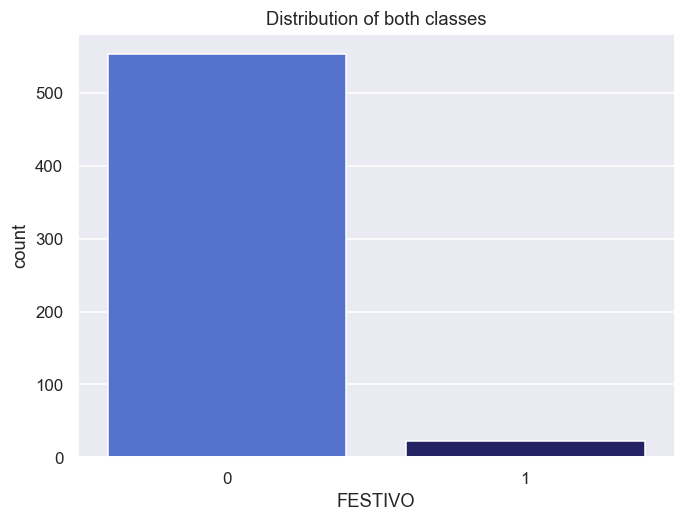

In [22]:
plt.figure(figsize=(7,5), dpi=110)
sns.countplot(x=df_aju_ts[target], palette=['royalblue', 'midnightblue'])
plt.title('Distribution of both classes')
plt.show()

El desbalanceo de clases genera que los modelos sufran de overfitting. Esto es muy común en problemas como por ejemplo la detección de fraude, donde se disponen de mucho más datos de la clase negativa que de la clase positiva. Por ello, para obtener un modelo que produzca buenos resultados, tenemos que aplicar técnicas de upsampling, como es el caso de `SMOTE`, las cuales nos permite aumentar el tamaño de observaciones correspondientes a la clase positiva. Más adelante se explicará en detalle la técnica usada para corregir el desbalanceo de clases, así como el código asociado a ello.

### Pipeline

Vamos a definir el Pipeline de procesado de datos, el cual nos servirá tanto para el training set como para el test set:

In [23]:
numeric_columns = continuous
categorical_columns = discrete
attributes = numeric_columns + categorical_columns
attributes

['CR00',
 'CR01',
 'CR02',
 'CR03',
 'CR04',
 'CR05',
 'CR06',
 'CR07',
 'CR08',
 'CR09',
 'CR10',
 'CR11',
 'CR12',
 'CR13',
 'CR14',
 'CR15',
 'CR16',
 'CR17',
 'CR18',
 'CR19',
 'CR20',
 'CR21',
 'CR22',
 'CR23',
 'TMIN',
 'TMAX',
 'DIASEM',
 'MES']

Definimos el Pipeline:

In [24]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder(handle_unknown='ignore', drop='first')

In [25]:
# Define individual Pipelines
# 1. Numeric
numeric_pipeline = Pipeline([
    ('std_scaler', std_scaler),
    ])
# 2. Categorical
categorical_pipeline = Pipeline([
    ('one_hot', one_hot)
    ])

In [26]:
# Define Full Pipeline
full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

Aplicamos el Pipeline sobre el dataset de entrenamiento:

In [27]:
# Get the attributes we're interested in
train_to_pipeline = df_aju_tr.loc[:, attributes]
# Apply the transformations
train_tr = full_pipeline.fit_transform(train_to_pipeline)
columns = full_pipeline.get_feature_names_out(attributes).tolist()
columns = [col.split("__")[-1] for col in columns]
train_tr = pd.DataFrame(train_tr, columns=columns, index=df_aju_tr.index)
# Check the result
train_tr.head()

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,CR10,CR11,CR12,CR13,CR14,CR15,CR16,CR17,CR18,CR19,CR20,CR21,CR22,CR23,TMIN,TMAX,DIASEM_2,DIASEM_3,DIASEM_4,DIASEM_5,DIASEM_6,DIASEM_7,MES_2,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
1952,1.260620,0.840060,1.256808,1.254556,1.177775,1.273398,-0.607102,-1.300114,-1.326258,-1.464415,-1.317827,-0.476111,-0.671572,-0.385874,-0.756295,-0.949312,-0.498416,1.005680,0.161977,-0.383408,-0.465072,1.232740,1.040251,0.800751,1.113249,2.511752,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
867,1.979130,1.076802,1.544708,1.551933,1.362950,1.146030,-0.087718,-1.391622,-1.173894,-1.106891,-1.257942,-0.573893,-0.092207,-0.238981,-0.127680,-0.121233,-0.329764,-0.267640,-0.690048,-0.945220,-1.245433,0.459735,1.263953,1.881582,-0.089031,0.065744,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
920,0.400844,-0.043932,-0.156253,-0.375729,-0.534319,-0.652836,-1.259200,-0.970462,-0.745990,-0.971855,-1.082277,-1.319322,-0.090163,0.854643,1.316271,1.981976,2.403357,1.788500,0.363447,-0.183306,-0.959068,0.079709,0.547272,0.865637,1.210731,1.261570,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2625,0.401176,0.319584,0.776867,1.049959,1.185049,1.543243,3.166940,1.747399,1.069887,0.713100,0.535377,0.596710,0.759972,0.274569,-0.747176,-0.906941,-1.173299,-1.669594,-1.691954,-1.767388,-1.496223,-0.775390,-0.259226,0.249131,-0.056537,-0.124501,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,-0.041790,-0.340944,-0.434710,-0.552819,-0.357232,-0.314428,0.416619,0.851661,0.419652,-0.020352,-0.123040,-0.203892,-0.415075,-1.100732,-0.437724,-0.235252,-0.102054,-0.323254,-0.452030,-0.659298,0.111060,2.296877,1.375521,0.630672,-0.219007,-0.042968,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finalmente obtenemos $X_{train}$ y $y_{train}$:

In [28]:
X_train = train_tr.copy()
y_train = df_aju_tr[target]

### Desbalanceo de clases

Cómo resolver el desequilibrio de clases

Existen dos posibilidades para solucionar el problema del desequilibrio de clases:

- Reducir los datos de la clase más grande, también conocido como ***downsampling***. Esta opción funciona bien cuando se tiene una gran cantidad de datos ya que aún se cuenta con un número significativo de instancias en cada clase luego de eliminar los datos de la clase más grande. Sin embargo, en este caso no es la mejor opción, ya que no se dispone de una cantidad de datos excesiva (y muy pocos datos de la clase minoritaria).

- Crear datos sintéticos para la clase más pequeña, conocido como ***upsampling***. Con esta técnica, la clase más pequeña tendrá el mismo número de instancias que la clase más grande.

En este caso, el submuestreo no es la mejor opción debido a la falta de datos, por lo que utilizaremos la técnica de ***downsampling***, específicamente la técnica SMOTE. Esta técnica funciona de la siguiente manera:

1. Se toma una muestra aleatoria de la clase más pequeña.
2. Se buscan los $k$ vecinos más cercanos a esa muestra.
3. Se elige al azar una instancia de esos $k$ vecinos más cercanos.
4. Se obtiene un vector entre la muestra aleatoria y el vecino seleccionado anteriormente.
5. Se multiplica ese vector por un número aleatorio entre $0$ y $1$.
6. Se obtiene una nueva muestra sintética.

Este proceso se repite $n$ veces hasta que la clase más pequeña tenga el mismo número de instancias que la clase más grande. En algunos casos, combinar ambas técnicas, submuestreo y sobremuestreo, puede dar mejores resultados, especialmente si utilizar solo sobremuestreo resulta en una cantidad mayor de datos sintéticos que reales en la clase minoritaria, lo que podría generar un gran sesgo en el modelo.

Por lo tanto, aplicaremos la técnica SMOTE al conjunto de entrenamiento:

In [29]:
SMOTE = SMOTE(random_state=2023)
X_train, y_train = SMOTE.fit_resample(X_train, y_train)

Comprobamos que tras aplicar `SMOTE` ambas clases están balanceadas:

In [30]:
y_train.value_counts(normalize=True).sort_index()

0    0.5
1    0.5
Name: FESTIVO, dtype: float64

Generamos de nuevo el mismo histograma que en caso anterior, de forma que se aprecia visualmente la diferencia tras haber aplicado `SMOTE`:

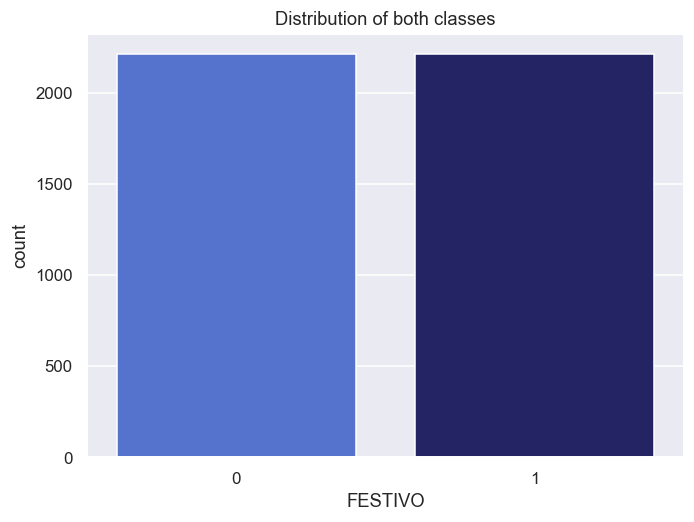

In [31]:
plt.figure(figsize=(7,5), dpi=110)
sns.countplot(x=y_train, palette=['royalblue', 'midnightblue'])
plt.title('Distribution of both classes')
plt.show()

Se puede apreciar que ahora se tiene el mismo número de observaciones de ambas clases.

A continuación aplicamos las mismas transformaciones que aplicamos en el Pipeline al dataset de test.

In [32]:
# Get the attributes we're interested in
test_to_pipeline = df_aju_ts.loc[:, attributes]
# Apply the transformations
test_tr = full_pipeline.transform(test_to_pipeline)
test_tr = pd.DataFrame(test_tr, columns=columns, index=df_aju_ts.index)
# Check the result
test_tr.head()

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,CR10,CR11,CR12,CR13,CR14,CR15,CR16,CR17,CR18,CR19,CR20,CR21,CR22,CR23,TMIN,TMAX,DIASEM_2,DIASEM_3,DIASEM_4,DIASEM_5,DIASEM_6,DIASEM_7,MES_2,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
139,0.962051,0.694993,0.835203,0.966244,0.827941,0.936723,-0.232629,-1.320206,-1.034886,-0.119785,1.214670,1.796358,1.616485,1.215648,0.623004,0.101568,-0.986295,-1.015749,-0.764630,-1.037853,-1.625560,-0.766747,0.483242,1.547206,0.300898,-0.423458,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1371,0.486880,0.142927,0.211116,0.230165,0.192324,0.102861,-0.800682,-0.278844,-0.470154,0.557020,0.965996,1.169250,0.709468,0.225697,-0.501650,-0.660198,-0.118167,-0.196035,-0.472071,0.102282,0.350450,-0.592322,-0.621364,-0.188407,1.015767,0.310345,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
984,0.494631,0.305878,0.602950,0.480042,0.466479,0.489823,-0.527704,-0.809990,-0.875445,-0.254074,0.578744,0.644214,0.450817,0.372039,0.042964,0.010918,0.333211,0.303760,-0.278587,-0.553229,0.082627,-0.901424,-0.061734,0.665596,0.950779,0.582123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2660,0.314115,0.411898,0.716906,1.092873,1.042821,1.250062,2.156379,1.255250,0.849776,0.230605,-0.126044,0.824117,1.819163,0.807679,0.703852,0.582676,0.100885,-0.840100,-1.572701,-1.918428,-2.290811,-1.365547,-0.549809,-0.066334,0.625838,1.315926,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2437,2.205074,1.781726,2.616072,2.730372,2.745224,2.625796,1.188138,-0.625514,-1.827572,-1.999935,-0.969032,0.560038,1.149231,0.393526,-0.550654,-1.073934,-1.707760,-2.179907,-1.781437,-1.301160,0.360599,-0.487342,-0.288327,0.181026,0.788308,0.337522,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Tras ello obtenemo $X_{test}$ y $y_{test}$:

In [33]:
X_test = test_tr.copy()
y_test = df_aju_ts[target]

Finalmente, para ver el performance el cada modelo, definimos la siguiente función que nos permite reutilizar código:

In [34]:
def metrics_summary(model, X, Y, threshold=0.5):
    predictions_proba = model.predict_proba(X)[:, 1]
    predictions = np.array([1 if i>threshold else 0 for i in predictions_proba])

    cm = metrics.confusion_matrix(Y, predictions)
    print('=========================\nConfusion matrix\n{}'.format(cm))

    cm_relative = np.round(metrics.confusion_matrix(Y, predictions, normalize='true'), 2)
    print('======================================\nConfusion matrix with percentages\n{}'.format(cm_relative))

    accuracy = metrics.accuracy_score(Y, predictions)
    print('=========================\nAccuracy\n{}'.format(accuracy))

    precision = metrics.precision_score(Y, predictions)
    print('=========================\nPrecision\n{}'.format(precision))

    recall = metrics.recall_score(Y, predictions)
    print('=========================\nRecall\n{}'.format(recall))

    f1 = metrics.f1_score(Y, predictions)
    print('=========================\nF1\n{}'.format(f1))

    roc_auc = metrics.roc_auc_score(Y, predictions_proba)
    print('=========================\nROC_AUC_SCORE\n{}'.format(roc_auc))
    print('=========================')

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

En este caso entrenaremos un árbol de decisión simple:

In [35]:
INPUTS_DT = columns

In [36]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

param_DT = {
    'DT__min_impurity_decrease': np.arange(0, 0.1, 0.005),
    'DT__min_samples_split': np.arange(1, 10, 1),
    'DT__min_samples_leaf': np.arange(1, 10, 1)
}

pipe_DT = Pipeline(steps=[ ('DT', DecisionTreeClassifier(criterion='gini',
                                                         random_state=2023))])

nFolds = 10
tree_fit = GridSearchCV(
    estimator=pipe_DT, # Structure of the model to use
    param_grid=param_DT, # Defined grid to search in
    n_jobs=-1, # Number of cores to use (parallelize)
    scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
    cv=nFolds
    ) # Number of Folds 
                        
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid
print("Decision Tree Trained")

Decision Tree Trained


Ahora vemos la mejor combinación de hiperparámetros obtenida:

In [39]:
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 1,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2023,
 'splitter': 'best'}

Tras ello obtenemos el CV score para este modelo:

In [42]:
# cv_tree = cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=10, scoring='accuracy')
# print('Accuracy in CV is:')
# cv_tree.mean()

Mostramos la estructura del árbol de decisión, de forma que podamos obtener mejor el proceso de toma de decisiones del modelo:

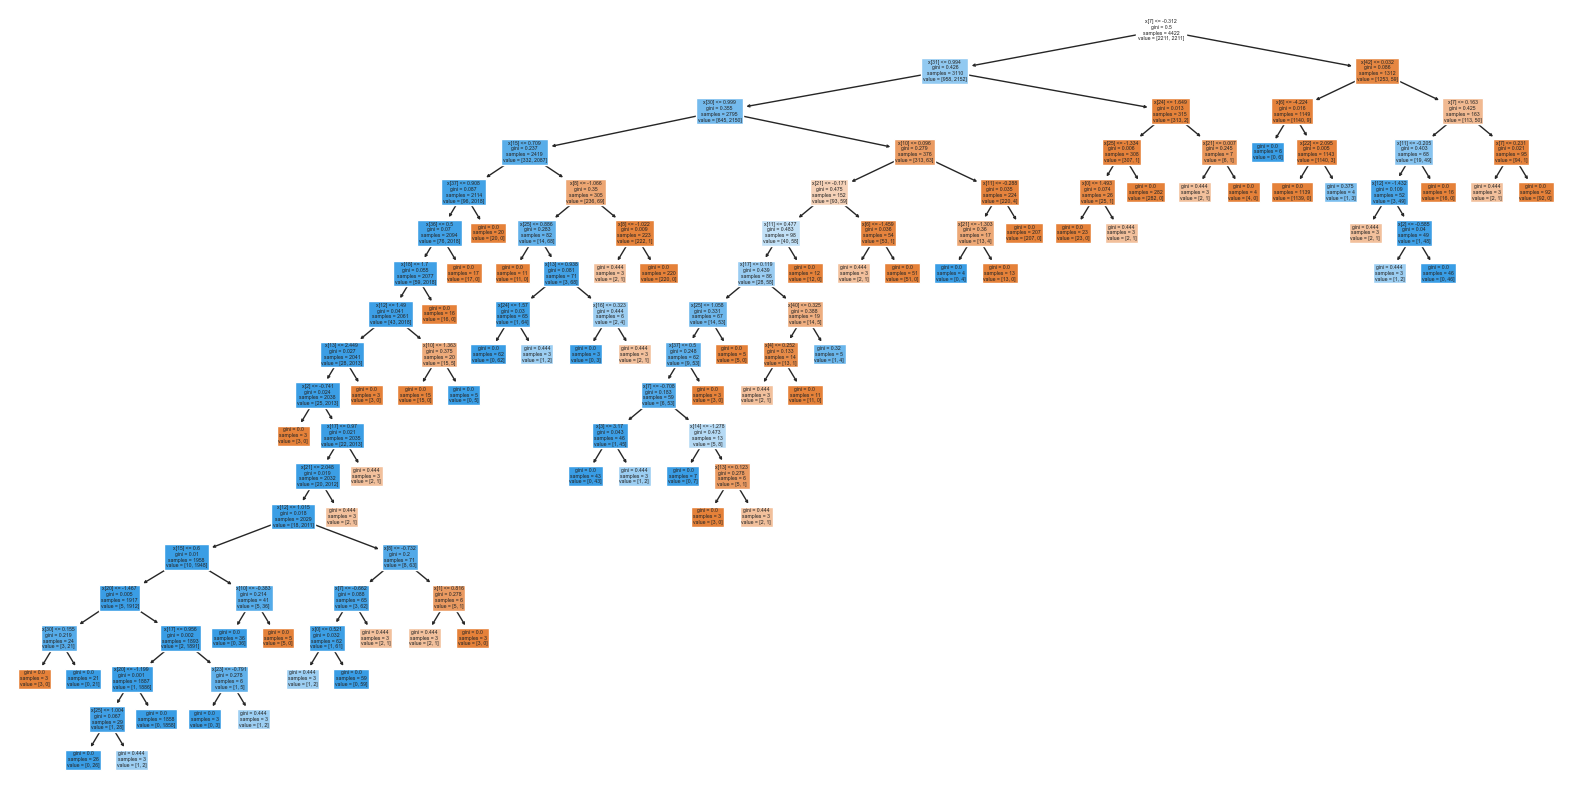

In [37]:
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

Adicionalmente mostramos cuales son las variables más importantes para el árbol:

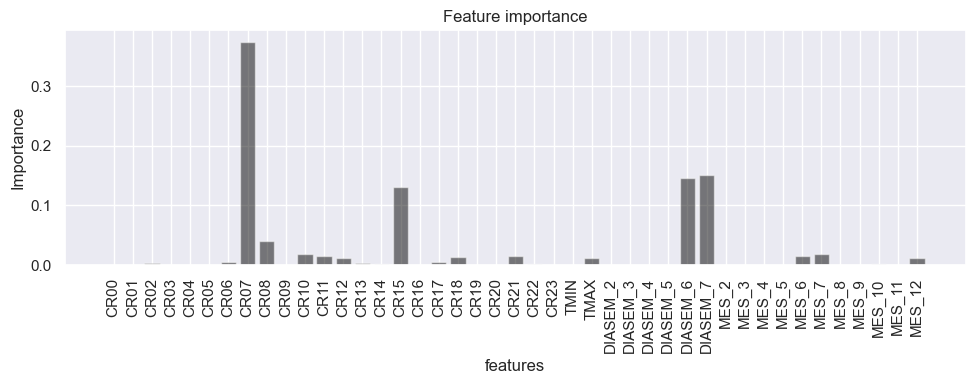

In [38]:
plt.figure(figsize=(10, 4))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns, rotation=90)
plt.tight_layout()
plt.show()

A continuación vamos a mostrar las métricas obtenidas por el árbol en el dataset de entrenamiento:

In [39]:
metrics_summary(tree_fit, X_train[INPUTS_DT], y_train, 0.5)

Confusion matrix
[[2203    8]
 [  13 2198]]
Confusion matrix with percentages
[[1.   0.  ]
 [0.01 0.99]]
Accuracy
0.9952510176390773
Precision
0.9963735267452403
Recall
0.9941203075531434
F1
0.9952456418383518
ROC_AUC_SCORE
0.9999305515921891


Mostramos estos resultados gráficamente:

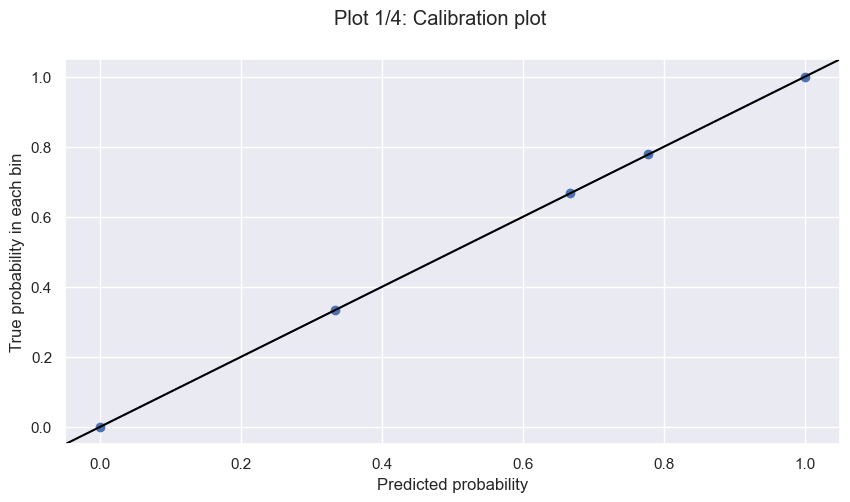

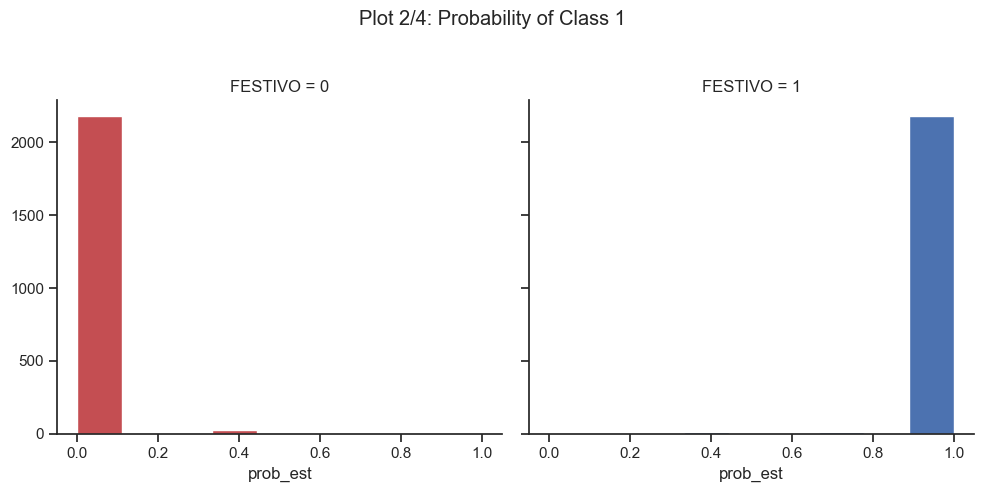

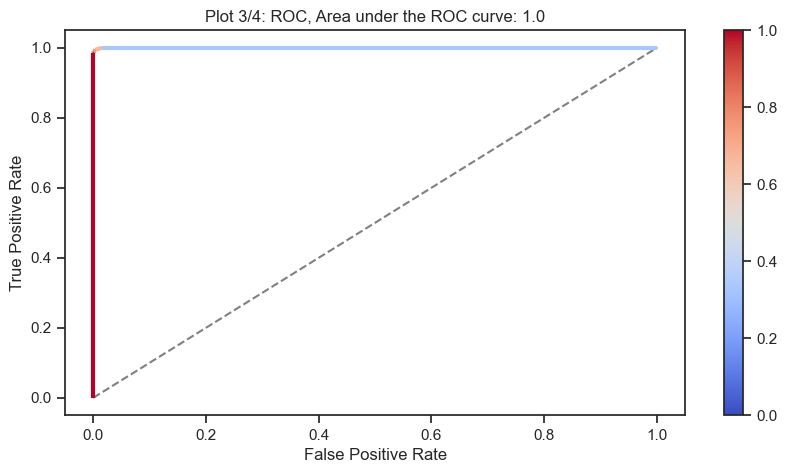

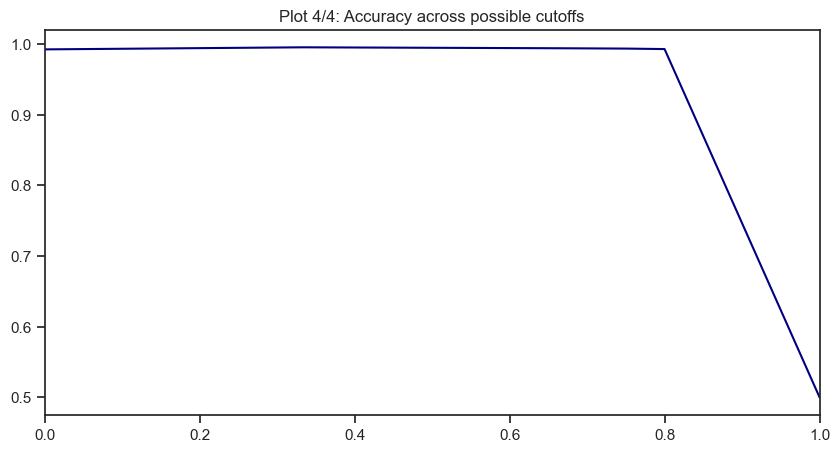

In [40]:
y_train = y_train.astype('category')
CT.plotClassPerformance(y_train, tree_fit.predict_proba(X_train[INPUTS_DT]), selClass = 1)
plt.show()

Ahora miramos esas mismas métricas, pero sobre el dataset de test:

In [43]:
metrics_summary(tree_fit, X_test[INPUTS_DT], y_test, 0.5)

Confusion matrix
[[541  12]
 [  7  16]]
Confusion matrix with percentages
[[0.98 0.02]
 [0.3  0.7 ]]
Accuracy
0.9670138888888888
Precision
0.5714285714285714
Recall
0.6956521739130435
F1
0.6274509803921569
ROC_AUC_SCORE
0.8784102523783316


Lo mostramos también gráficamente:

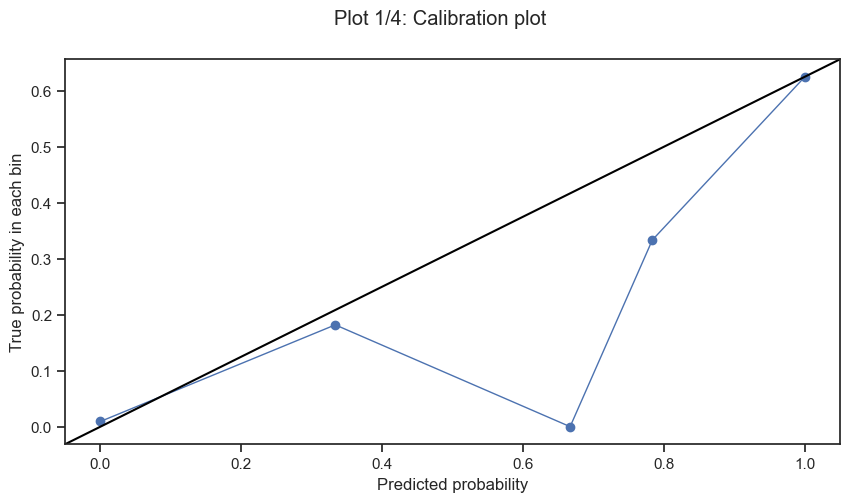

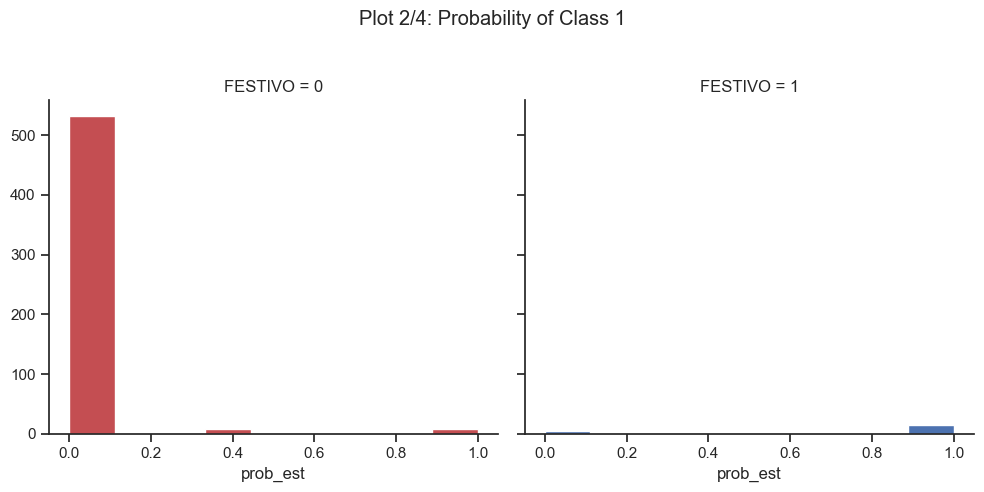

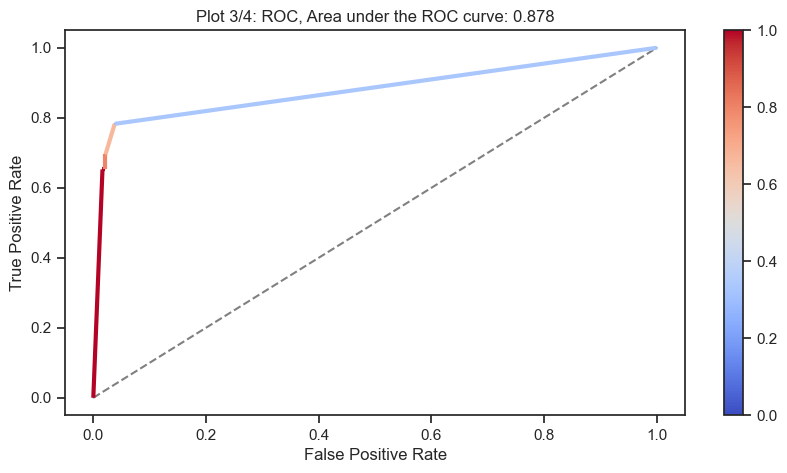

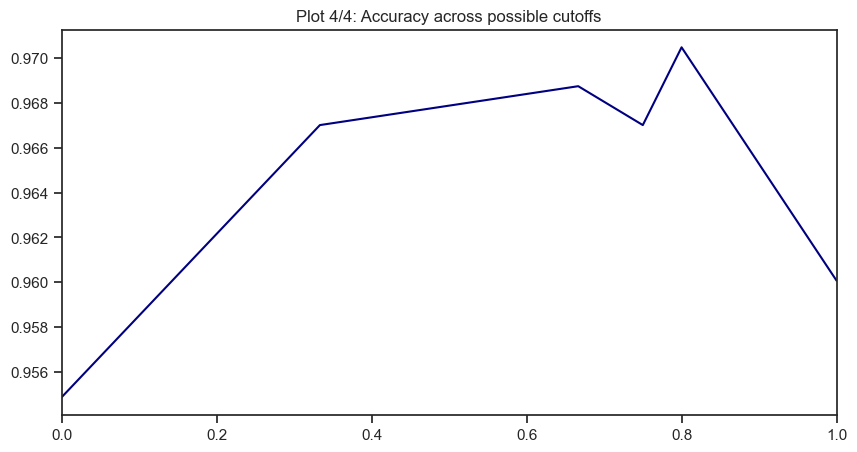

In [44]:
y_test = y_test.astype('category')
CT.plotClassPerformance(y_test, tree_fit.predict_proba(X_test[INPUTS_DT]), selClass = 1)
plt.show()

#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [8]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [9]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [10]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.6. Utiliza staking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

In [11]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


In [12]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

In [13]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [5]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('data/input/VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_val

Tamaño de df_val con los datos cargados: (357, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2022-01-01,0.038935,0.037313,0.035291,0.033673,0.032924,0.033235,0.034250,0.035303,0.037974,...,0.051431,0.050366,0.047399,0.043002,0.039327,1,6,1,14.1,25.3
1,2022-01-02,0.035271,0.033313,0.031889,0.031411,0.031302,0.031975,0.033854,0.035571,0.039449,...,0.052162,0.050877,0.047856,0.043245,0.038792,1,7,0,14.5,24.9
2,2022-01-03,0.033756,0.032003,0.030669,0.030051,0.030199,0.031280,0.034230,0.037862,0.042149,...,0.052212,0.051153,0.047885,0.042709,0.038054,1,1,0,11.3,23.8
3,2022-01-04,0.034484,0.032505,0.031375,0.030540,0.030431,0.031324,0.034787,0.038767,0.042558,...,0.052198,0.051378,0.047963,0.043061,0.038486,1,2,0,10.8,23.0
4,2022-01-05,0.034669,0.032213,0.030933,0.030382,0.030527,0.031611,0.034651,0.038108,0.041891,...,0.051285,0.050828,0.048133,0.043639,0.039127,1,3,0,14.7,22.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2022-12-27,0.033279,0.031139,0.029907,0.029433,0.029757,0.030972,0.034595,0.038379,0.042911,...,0.052135,0.050948,0.047933,0.042347,0.037164,12,2,0,20.6,23.5
353,2022-12-28,0.033250,0.031186,0.029934,0.029447,0.029821,0.030942,0.033929,0.037831,0.042330,...,0.051762,0.050446,0.047250,0.042042,0.037155,12,3,0,18.7,24.1
354,2022-12-29,0.033718,0.031695,0.030290,0.029717,0.030014,0.031075,0.034526,0.038393,0.043134,...,0.051901,0.050019,0.046786,0.041653,0.037101,12,4,0,18.0,24.6
355,2022-12-30,0.033673,0.031494,0.030124,0.029639,0.029629,0.030732,0.033926,0.037799,0.042977,...,0.052022,0.050441,0.046984,0.042434,0.037864,12,5,0,15.7,24.1


#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [15]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

In [16]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
